# Operando sobre Datasets criados a partir de um EPM Server

Os exemplos deste artigo mostram como utilizar as ferramentas que o Python oferece para manipular arquivos *".h5"* que foram gerados a partir do **EPMTagPort**.

Para demonstração, analisaremos dados de processos de medições feitas por um sensor de temperatura em um determinado período de tempo que estão armazenados em um arquivo que foi previamente gerado pela ferramenta (*datasets/example.h5*).

## Importação dos módulos Python utilizados para manipulação de arquivos HDF5, análises e visualizações

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import h5py as h5
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Leitura do Arquivo

Antes de começar a análise dos dados salvos no arquivo no formato [HDF5](https://www.hdfgroup.org/), é necessário realizarmos algumas etapas preparatórias que consistem em definir as configurações de leitura do arquivo.

Com o auxílio da biblioteca [pandas](https://pandas.pydata.org/), previamente carregada, que possui algumas funções para a manipulação de arquivos [HDF5](https://www.hdfgroup.org/), utiliza-se o método *HDFStore* passando como parametro uma *string* com nome do arquivo seguido do modo no qual será acessado o mesmo ('r' = leitura).

Assim que o arquivo estiver aberto, é possivel listar os *Datasets* das *Basic Variables* (variáveis do **EPM Server**, também designadas por *Tags*) que estão no [HDF5](https://www.hdfgroup.org/) usando o comando *hdf_file.keys()*.

> **NOTA**
>
> É recomendado começar o processo de leitura do arquivo criando uma variável que armazena a localização do arquivo *".h5"* para eventuais utilizações posteriores, bem como facilitar a sua utilização em outras análises.

In [2]:
filePath = 'datasets/example.h5'
hdf_file = pd.HDFStore(filePath, mode='r')
tagsOnFile = hdf_file.keys()
print(f'Lista das variáveis no arquivo:{tagsOnFile}')

Lista das variáveis no arquivo:['/Datasets/MeetingRoom10th_Temperature', '/Datasets/MeetingRoom11th_Temperature', '/Datasets/MeetingRoom12th_Temperature']


C:\Anaconda3\lib\site-packages\tables\group.py:1187: UserWarning: problems loading leaf ``/Informations/Informations``::

  variable length strings are not supported yet

The leaf will become an ``UnImplemented`` node.
  % (self._g_join(childname), exc))


## Preparação dos dados para análise

Algumas das informações contidas no arquivo [HDF5](https://www.hdfgroup.org/) gerado pelo **EPMTagPort** estão em um formato que facilita a importação e exportação de dados, mas que não são de fácil entendimento na hora das análises, para isso são necessárias algumas operações que visam facilitar esse processo.

Com a listagem das *Basic Variables* que estão no arquivo, antes de selecionar a variável de interesse para análise, é recomendado fazer a conversão de uma das colunas dos *datasets* do [HDF5](https://www.hdfgroup.org/) pois, por padrão, a coluna *Timestamp* que é referente à data-hora que foi executada a medição do registro, é armazenada na forma de um número inteiro, que simboliza o numero de milissegundos decorridos a partir de uma data inicial, por padrão o **EPMTagPort** utiliza a data *1/1/2000 00:00:00 AM*.

Para atingir esse resultado de conversão de um valor inteiro para uma informação de data-hora nativa da linguagem Python, pode-se utilizar de um laço *for* da linguagem Python com os elementos da lista de *Basic Variables* que foi previamente lida.
Junto ao laço para a conversão do *Timestamp* é possível perceber um trecho de código que também serve de auxilio para a parte de análise mas que não tem uma obrigatoriedade na sua execução.

Esse comando serve para filtrar as informações de cada *dataset* removendo as que são nulas através da coluna *IsNull* que possui um valor inteiro de "1" quando a informação é nula e "0" caso contrário.
Ele também opera sobre a informação referente à qualidade da medida (campo *Quality*), que assume o valor "0" quando a medição possui qualidade boa (padrão [OPC UA](https://opcfoundation.org/about/opc-technologies/opc-ua/)).

> **NOTA**
>
> Estas operações são necessárias pois estamos utilizando diretamente a lingaugem Python para manipular os *datasets*, no caso de se utilizar a ferramenta *unpack* do **EPMTagPort** todos estes processamentos são feitos automaticamente e as variáveis, bem como seus conjuntos de dados, passam a estar disponíveis em um **EPM Server** destinado exclusivamente à análises *off-line**.

In [3]:
#As the timestamp column is a number, we need to covert it into a DateTime.
#The standard datetime that TagPort uses to calculate the timestamp is January 1st of 2000, at 00:00:00h
startDate = pd.Timestamp('2000-1-1 00:00:00')
basicVariables = {}
for tag in tagsOnFile:
    basicVariables[tag] = hdf_file.get(tag)
    basicVariables[tag]['Timestamp'] = pd.to_datetime(basicVariables[tag]['Timestamp'], origin=startDate,unit='ms')
    # Here we are filtering the data to remove the null values and values that are not good
    basicVariables[tag] = basicVariables[tag].loc[
        (basicVariables[tag]['Quality'] == 0) &
        (basicVariables[tag]['IsNull'] == 0)
    ]

Após usar um iterador para ajustar a coluna de *Timestamp* de todas as *Basic Variables* que estão no arquivo, é possivel trabalhar com os dados da forma desejada.

Abaixo é usada a função *plot* do módulo [matplotlib](https://matplotlib.org/) para gerar gráficos com as variáveis carregadas e pré-processadas do arquivo *example.h5*.

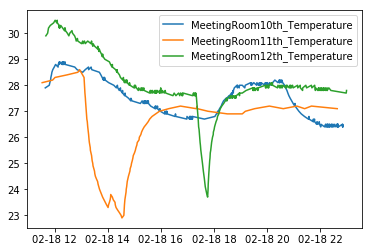

In [4]:
colorArray = {'r','b','g','y'}
iterator = 0
for tag in basicVariables:
    plt.plot(basicVariables[tag]['Timestamp'],basicVariables[tag]['Value'],label=tag.replace('/Datasets/',''))
    iterator = iterator+1
plt.legend(loc = 'best')

## Acessando atributos

Na estrutura padrão gerada pelo **EPMTagPort** o recurso de atributos do [HDF5](https://www.hdfgroup.org/) foi utilizado tanto para disponibilizar informações referente ao arquivo no geral quanto para cada *dataset* mostrando algumas informações da *Basic Variable* que está salva.

A imagem abaixo representa a estrutura do arquivo [HDF5](https://www.hdfgroup.org/) gerado pelo **EPMTagPort** e com ela é possível visualizar os metadados que possuem informações do *dataset* e também o que contém as informações do pacote, que se localiza no grupo *Informations*.

![text](images/HDF5_Hierarquia.png "Titulo")

Para acessar os metadados de um *dataset* é necessário utilizar uma biblioteca diferente da que foi usada anteriormente, pois o módulo [pandas](https://pandas.pydata.org/) (*na versão utilizada*) não permite a leitura de *strings* armazenadas no [HDF5](https://www.hdfgroup.org/).

Utilizando o módulo [h5py](https://www.h5py.org/) o processo inicial é semelhante ao realizado anteriormente com o módulo [pandas](https://pandas.pydata.org/), usando o método *File* e passando como argumento nome do arquivo, que foi previamente atribuído a variável *filePath* e, posteriormente, o modo de acesso ao arquivo.

In [5]:
#On the HDF5 that TagPort generates we have one dataset that stores informations about the package
hdf_fileAtribbs = h5.File(filePath, 'r')
InfoGroup = hdf_fileAtribbs.get('Informations').get('Informations')

Como dito anteriormente, as *Basic Variables* possuem diversas informações advindas do **Sistema EPM**, que podem ser úteis durante o processo das análises. A seguir são apresentadas as informações que o **EPMTagPort** empacota:

* **CastType** - informa se foi realizada alguma operação de coerção de tipo na *Basic Variable* do **Sistema EPM** antes de armazená-la.
* **DeadBand** - esse atributo tem relação a um dos facilitadores que serão declarados posteriormente neste documento, indicando se foi aplicado um filtro durante o processo de armazenamento dos valores lidos do processo. 
* **DeadBandUnit** - informa a unidade de medida utilizada na configuração do filtro *Dead Band*.
* **Description** - descrição da *Basic Variable* no **Sitema EPM**.
* **Discrete** - atributo que indica se a variável tem uma natureza discreta ou contínua (0 para contínua, 1 para discreta).
* **EU** - unidade de medida da *Basic Varaible*, também designada por Unidade de Engenharia.
* **Name** - nome da *Basic Variable* no **Sistema EPM** (também designado por *Tag*).
* **Clamping** - informação referente ao tratamento sobre os dados de processo em relação aos limites definidos para a variável no **Sistema EPM**.
* **HighLimit** - limite superior definido para a *Basic Variable*.
* **LowLimit** - limite inferior definido para a *Basic Variable*.

Para facilitar a utilização das informações acima, é recomendado criar uma estrutura de dados do tipo *Dicionário* do Python, que possui uma coleção de chave e valor. Estes dicionários são descritos a seguir:

* **convert** - *Dictionary* que seleciona se os atributos lidos de um *dataset* específico são do tipo *string* (Arquivos [HDF5](https://www.hdfgroup.org/) armazenam *strings* de uma maneira própria, demandando uma operação de *decoding* da mensagem).
* **clamping** - Opção que mostra como os dados foram tratados pelo Sistema EPM em relação aos limites estabelecidos das configurações de Unidade de Engenharia, que podem ser:
    * 0 - **None**: Os dados do EPM nao foram tratados de forma alguma.
    * 1 - **Discard**: O tratamento usado nos dados do EPM descarta os dados que excedem os limites de máximo e mínimo.
    * 2 - **Clamp To Range**: O servidor EPM substitui os dados que excederam os limites pelo valor do limite que foi excedido.

In [6]:
convert = { 0:'No', 1:'Yes' }
clamping = { 0:'None',1:'Discard',2:'Clamp To Range' }
deadBandUnit = {0:'None', 1:'Valor Absoluto', 2:'Percentual do Range', 3:'Percentual do Valor'}
castTypeDictionary = {0:'Source Type',1:'Bit',2:'Integer',3:'Unsigned Integer',4:'Float',5:'Double',6:'String',7:'DateTime'} # FALTA IMPLEMENTAR ISSO PARA FACILITAR A LEITURA DO CAST TYPE NO FINAL DO DOCUMENTO

Como dito anteriormente, as bibliotecas do [HDF5](https://www.hdfgroup.org/) necessitam de um trabalho extra na leitura de informações ou atributos do tipo *string*, pois como o [HDF5](https://www.hdfgroup.org/) é um arquivo que armazena suas estruturas e informaçoes de uma forma binária, seus dados necessitam de uma conversão passando qual o *Encoding* utilziado na hora do empacotamento dos dados.

Abaixo é possivel ver o uso de um laço *for* do python para iterar sobre as informações do arquivo [HDF5](https://www.hdfgroup.org/) e fazendo a conversão do binário para *string*.

In [7]:
fileInformations = {}
infoIterator = 0
for information in InfoGroup[0]:
    fileInformations[InfoGroup[0][infoIterator].decode('utf-8')]=InfoGroup[1][infoIterator].decode('utf-8')
    infoIterator = infoIterator + 1

Ao analisar o conteúdo do arquivo, é possivel reparar nas informações gerais do empacotamento realizado, como data-hora de início e fim dos dados que foram registrados, o número de *Tags* que foram incluidas no arquivo e, por fim, algumas informações sobre o **EPMTagPort** como a versão e o *Time Stamp* inicial usado para definir a data base para cálculo do valor interire referente ao *Timestamp*.

In [8]:
fileInformations

{'EndPeriod: ': '02/18/2019 23:00:00',
 'NumBVS: ': '3',
 'StartPeriod:': '02/18/2019 00:00:00',
 'TimestampStart:': '01/01/2000 00:00:00',
 'Version 1.0.0': ''}

Para adquirir os metadados de cada dataset é necessário navegar no arquivo [HDF5](https://www.hdfgroup.org/), entrando no grupo dos datasets e selecionando qual tag será analisado.

No exemplo a aquisição dos metadados é feita em todos os datasets contidos no arquivo, e os passos de aquisição consistem em selecionar o tag e, assim como dito anteriormente que o HDF5 é análogo a uma cadeia de diretórios e arquivos, se torna necessário remover o "path" até o dataset desejado.

Usando um laço duplo que varre todos os atributos do dataset e depois por cada dataset, é possivel reparar uma regra de validação utilizando a "key" do dictionary gerado para salvar os atributos, essa key verifica se o atributo que o laço está percorrendo é do tipo "Discrete", "DeadBandUnit" ou "RangeClamping" e, caso seja, é feita uma conversão utilizando os facilitadores declarados no inicio deste exemplo. Caso os atributos nao possuam uma conversão, o laço simplesmente atribui ao dictionary aquele valor.

In [9]:
tagInformations = {}
datasetGroup = hdf_fileAtribbs.get('Datasets')
bvList = list(datasetGroup.keys())
for tag in tagsOnFile:
    tagName = tag.replace('/Datasets/','')
    attrKeys = list(datasetGroup.get(tagName).attrs.keys())
    attrValues = list(datasetGroup.get(tagName).attrs.values())
    attrDictionary = {}

    for key,value in zip(attrKeys,attrValues):
        if type(value[0]) == bytes:
            attrDictionary[key] = value[0].decode('iso-8859-1')
        else:
            if key == 'Discrete' or key == 'DeadBandUnit':
                attrDictionary[key] = convert[value[0]]
            elif key == 'Clamping':
                attrDictionary[key] = clamping[value[0]]
            elif key =='CastType':
                attrDictionary[key] = castTypeDictionary[value[0]]
            else:
                attrDictionary[key] = value[0]               
    tagInformations[tagName] = attrDictionary   

Abaixo são listados os atributos atrelados à primeira *Basic Variable* da lista obtida pelo arquivo.

In [10]:
tagInformations[bvList[0]]

{'CastType': 'Float',
 'Clamping': 'Discard',
 'DeadBand': 0.0,
 'DeadBandUnit': 'No',
 'Description': 'NÃO APLICAR COMPRESSÃO DE DADOS - TAG utilizado para análises!',
 'Discrete': 'No',
 'EU': '°C',
 'EuID': 10035,
 'HighLimit': 50.0,
 'LowLimit': -10.0,
 'Name': 'MeetingRoom10th_Temperature',
 'StructType': 'Float'}

In [11]:
# Mostra apenas os 10 primeiros valores
basicVariables[tagsOnFile[0]][0:10]

,Timestamp,Quality,IsNull,Value
1,2019-02-18 11:38:56.366,0,0,27.900000
2,2019-02-18 11:47:56.000,0,0,28.000000
3,2019-02-18 11:49:16.000,0,0,28.100000
4,2019-02-18 11:50:56.000,0,0,28.200001
5,2019-02-18 11:51:36.000,0,0,28.299999
6,2019-02-18 11:52:56.000,0,0,28.400000
7,2019-02-18 11:53:56.000,0,0,28.500000
8,2019-02-18 11:55:56.000,0,0,28.600000
9,2019-02-18 11:59:16.000,0,0,28.700001
10,2019-02-18 12:02:16.000,0,0,28.799999
